# 1. Zadaća - Filip Skrinjar
## Pregled nekih algoritama strojnog učenja

Kako bi demonstrirali neke algoritme strojnog učenja koristit ćemo podatke sa Quandl repozitorija. Da bi mogli koristiti Quandl u pythonu potrebno nam je bilo instlairati njihov paket te onda možemo preuzimati podatke od njih direktno bez dodatnih datoteka.

In [2]:
import quandl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
podatci = quandl.get("LME/PR_CO", authtoken="Bygw8KP9XWpisC6gGapq") #cijene kobalta
podatci.columns

Index(['Cash Buyer', 'Cash Seller & Settlement', '3-months Buyer',
       '3-months Seller', '15-months Buyer', '15-months Seller'],
      dtype='object')

In [5]:
podatci.head()

,Cash Buyer,Cash Seller & Settlement,3-months Buyer,3-months Seller,15-months Buyer,15-months Seller
Date,,,,,,
2012-01-03,29750.0,30350.0,29500.0,30100.0,28375.0,29375.0
2012-01-04,31500.0,32000.0,31250.0,31750.0,30075.0,31075.0
2012-01-05,32350.0,32500.0,31500.0,32000.0,30330.0,31330.0
2012-01-06,32250.0,32700.0,31000.0,32000.0,30075.0,31075.0
2012-01-09,31800.0,32300.0,31300.0,31800.0,30125.0,31125.0


In [6]:
podatci.mean()

Cash Buyer                  34746.536260
Cash Seller & Settlement    35258.597328
3-months Buyer              34705.607506
3-months Seller             35314.745547
15-months Buyer             34614.847964
15-months Seller            35614.847964
dtype: float64

In [16]:
podatci = podatci - podatci.mean()
podatci = podatci / podatci.max()
podatci

,Cash Buyer,Cash Seller & Settlement,3-months Buyer,3-months Seller,15-months Buyer,15-months Seller
Date,,,,,,
2012-01-03,-0.082925,-0.081482,-0.086337,-0.086645,-0.103764,-0.103764
2012-01-04,-0.053881,-0.054092,-0.057312,-0.059230,-0.075494,-0.075494
2012-01-05,-0.039774,-0.045792,-0.053166,-0.055076,-0.071254,-0.071254
2012-01-06,-0.041434,-0.042472,-0.061459,-0.055076,-0.075494,-0.075494
2012-01-09,-0.048902,-0.049112,-0.056483,-0.058399,-0.074663,-0.074663
2012-01-10,-0.045583,-0.037492,-0.061459,-0.055076,-0.075494,-0.075494
2012-01-11,-0.041434,-0.045792,-0.049020,-0.055076,-0.068842,-0.068842
2012-01-12,-0.037285,-0.037492,-0.044873,-0.046934,-0.062690,-0.062690
2012-01-13,-0.020688,-0.020893,-0.036581,-0.038460,-0.054292,-0.054292


promatrati ćemo stupac Cash Buyer te ćemo ogledati kako razlićiti regresijski modeli opisuju kretanje cijena kobalta

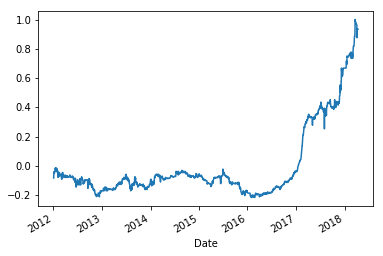

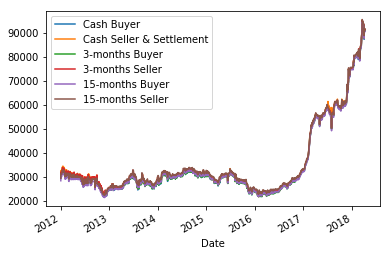

In [20]:
cijena = podatci["Cash Buyer"].as_matrix(columns= None)  #y vrijednosti

podatci["Cash Buyer"].plot()
quandl.get("LME/PR_CO", authtoken="Bygw8KP9XWpisC6gGapq").plot()

In [26]:
print( "standardan devijacija: ",podatci["Cash Buyer"].std() , " medijan : ",podatci["Cash Buyer"].median() ) 

standardan devijacija:  0.2521048222036235  medijan :  -0.0870744341294881


In [43]:
print("25%-tni kvantil: ",podatci["Cash Buyer"].quantile(0.25) , "\n75%-tni kvantil: ",podatci["Cash Buyer"].quantile(0.75)) 

25%-tni kvantil:  -0.13686410286824335 
75%-tni kvantil:  -0.04558304351385878


In [44]:
podatci["Cash Buyer"].skew()

1.9862586185820499

Pozitivni skew nam govori da je desna rep podataka ili deblji ili duži, što vidimo i iz grafa. 

Također, odmah vidimo da regresija pravcem nece dobro opisivati podatke jer je cijena skoro stalno rasla od 2017 godine. Ali svejedno ćemo napraviti i regresiju pravcem jer ćemo je uspoređivati kasnije sa drugima

In [45]:
X = np.c_[np.ones(len(cijena)) , range(len(cijena)) ]
initTheta = np.array([0,0])

za računanje koeficjenata našeg modela trebati će nam dvije funkcije, jedna koja će računati koliko naš model dobro opisuje podatke koristeći sumu kvadratnog odstupanja, a druga će biti funkcija koja će gradijentnim spustom izračunati optimalnu vrijednost našeg parametra

In [46]:
def LinRegComputeCost(X ,y ,theta ):
    m = len(y)
    h = np.dot(X, theta)
    J = (1/(2*m)) * np.sum(np.power(h-y,2))
    return J

In [47]:
def gradientDescent(X, y, theta, alpha, num_iters):
    m = len(y)
    J_povijest = np.zeros(num_iters)
    for i in range(0, num_iters):
        h = np.dot(X,theta)
        grad = np.dot(X.transpose(), h-y)/m
        theta = theta - alpha*grad
        J_povijest[i] = LinRegComputeCost(X ,y ,theta)
    return theta, J_povijest   

In [79]:
br_iteracija = 1500
alpha = 0.01
X_train = X[ :int(0.7*len(X)), : ]  #prvih 70%
X_test = X[int(0.7*len(X)):, : ]
y_train = cijena[ :int(0.7*len(cijena))]  
y_test = cijena[ int(0.7*len(cijena)): ]


(array([-0.000174  , -0.00016098]), 0.0021663412125716196)

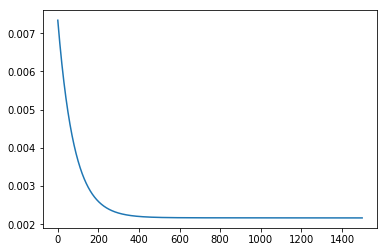

In [82]:
optimal_theta, J_history = gradientDescent(X_train, y_train, initTheta, 0.00000495, br_iteracija)
plt.plot(J_history)
plt.show()

vidimo da smo gradijentnim spustom našli približno optimalno rješenje

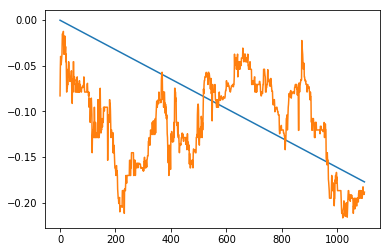

In [86]:
fig1, ax1 = plt.subplots()
ax1.plot(X_train[:,1], np.matmul(X_train,optimal_theta))
ax1.plot(X_train[:,1], y_train)

Uzimajući u obzjer velike oscilacije u podatcima izgleda dosta dobro. no pogledajmo kako se pravac ponaša na testnom skupu

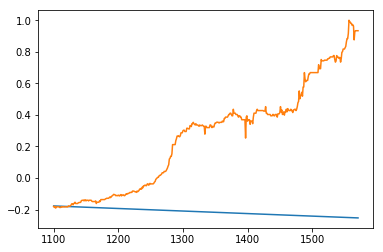

In [88]:
plt.plot(X_test[:,1], np.matmul(X_test,optimal_theta))
plt.plot(X_test[:,1], y_test)

Na testnom skupu naš pravac _nimalo_ ne opisuje podatke! Zašto ? Zbog toga što smo naše podatke particionirali na prvih 70% i na zadnjih 30%. No naši podatci imaju veliki _skew_ pa je rep podataka upao *samo* u testni dio podataka. Pametnije particioniranje skupa podataka je da ne uzimamo prvih 70% i zadnjih 30% nego da odaberemo nasumično 70% za treniranje i 30% za test. To možemo napraviti tako da koristimo permutacije

In [49]:
def particioniranje(X,y):
    m = X.shape[1]
    Xy = np.c_[X , y]
    Xyperm = np.random.permutation(Xy)
    X_train = Xyperm[ :int(0.7*len(X)), :m ]  #prvih 70%
    X_test = Xyperm[ int(0.7*len(X)):, :m ]
    y_train = Xyperm[ :int(0.7*len(X)), m ]  
    y_test = Xyperm[ int(0.7*len(X)):, m ]
    return X_train, X_test, y_train, y_test

In [107]:
X2_train, X2_test, y2_train, y2_test = particioniranje(X, cijena)
optimal_theta2, J_history2 = gradientDescent(X2_train, y2_train, initTheta, 0.000002, br_iteracija)
optimal_theta2, J_history2[-1]

(array([-1.99854237e-04,  7.76706867e-05]), 0.026610462664262282)

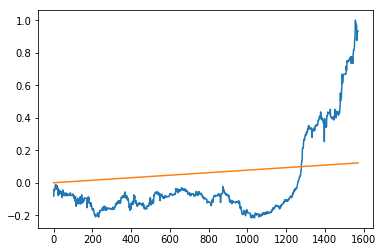

In [108]:
fig2, ax2 = plt.subplots()
ax2.plot(X[:,1], cijena)
ax2.plot(X[:,1], np.dot(X,optimal_theta2))

In [109]:
LinRegComputeCost(X,cijena,optimal_theta) - LinRegComputeCost(X,cijena,optimal_theta2) 

0.025481617126531415

razlika je praktički neprimjetna, no razlog tome je najviše to što dani podatci nisu prikladni za regresiju pravcem. zato nastavljamo sa polinomijalnom regresijom 

In [115]:
tempsqr = np.power(range(len(cijena)),2)
Xsqr = np.c_[X , tempsqr]
initTheta= np.array([0,0,0])
Xsqr_train, Xsqr_test, y_train, y_test = particioniranje(Xsqr, cijena)
optimal_theta3, J_history3 = gradientDescent(Xsqr_train, y_train, initTheta, 0.000000000001, br_iteracija)
optimal_theta3

array([-1.43700141e-10, -5.98615350e-08,  1.19309533e-07])

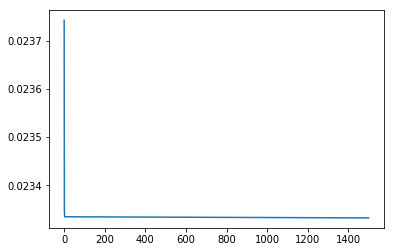

In [116]:
plt.plot(J_history3)    

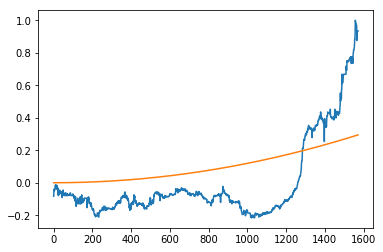

In [117]:
fig3, ax3 = plt.subplots()
ax3.plot(X[:,1], cijena)
ax3.plot(X[:,1], np.dot(Xsqr,optimal_theta3))

iako po grafu kretanja cijene funkcije izgleda kao da nas je gradijentni spust doveo priblizno blizu lokalnog optimuma, vidimo da naša krivulja ne opisuje dobro podatke kao što bi mogli očekivati. glavni razlog tome je jako mali parametar alpha kojeg smo morali koristiti, naime $alpha$ = 0.000000000001 kod gradijentnog spusta sto znaci da se naš algoritam spušta jako polako. idemo zato pogeldati plohu funkcije cijene u ovisnosti o parametru $theta$ 

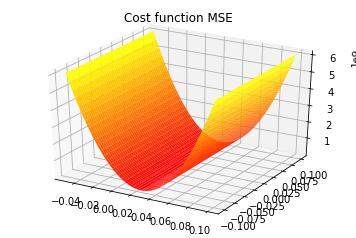

In [130]:
%matplotlib agg
from matplotlib import cm

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
thetax, thetay = np.meshgrid( np.linspace(-0.05,0.1,300), np.linspace(-0.1,0.1,300) ) 
cost = np.zeros((300,300))
for i in range(0,300):
    for j in range(0,300):
      cost[i,j] = LinRegComputeCost(Xsqr_train, y_train, np.array([0, thetax[0][i], thetay[j][0]])) 
  

ax.plot_surface(thetax, thetay, cost, cmap=cm.autumn, linewidth=1)
ax.set_title('Cost function MSE')
fig

vidimo da je naša vrijednost za parametar $theta$ = (-1.43700141e-10, -5.98615350e-08,  1.19309533e-07])) koju smo našli gradijentnim spustom stvarno dobra aproksimacija lokalnog optimuma, samo što su podatci takvi da mala promjena u veliČini parametara uvelike utječe na rast cijene, razlog tome je naravno veliki broj mjerenja. 

obzjerom da prevelik broj podataka stvara probleme kod računanja, jedno od mogućih rješenja je smanjivanje podataka. naime naša mjerenja su na dnevnoj bazi te zato svako pojedino mjerenje ne mijenja previše stanje dionica, dakle da izbacivanjem nekih mjerenja nebi se trebala uvelike narušiti krivulja kretanja cijena pa mozemo pretpostaviti da ce model istreniran na manjem skupu podataka dobro opisivati i veći skup podataka 

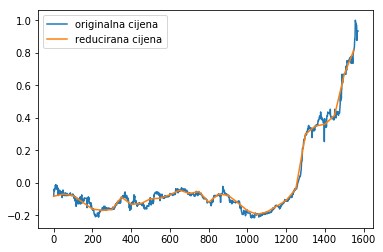

In [177]:
redCijena = cijena[0::50]
figUsporedba, axUsporedba = plt.subplots()
axUsporedba.plot(range(cijena.size),cijena, label="originalna cijena")
axUsporedba.plot(np.multiply(range(redCijena.size),50), redCijena, label="reducirana cijena")
plt.legend()
figUsporedba

In [175]:
Xred = np.c_[range(len(redCijena)) , np.power(range(len(redCijena)),2)]
Xred = np.c_[np.ones(len(redCijena)) ,Xred]
Xred
redXtrain, redXtest, redYtrain, redYtest = particioniranje(Xred,redCijena)
opt_theta, J_historyRed = gradientDescent(redXtrain, redYtrain, initTheta, 0.00001, 10000)
opt_theta

array([-0.00336979, -0.03033032,  0.00143248])

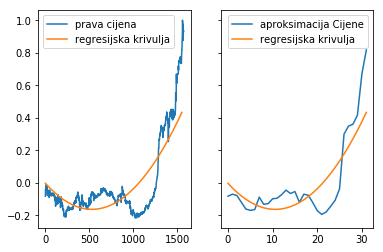

In [179]:
figRed, (axRed1, axRed2) = plt.subplots(1, 2, sharey=True)
axRed1.plot(X[:,1], cijena, label = "prava cijena")
axRed1.plot(np.multiply(Xred[:,1],50), np.dot(Xred,opt_theta), label = "regresijska krivulja")
axRed2.plot(Xred[:,1], redCijena, label = "aproksimacija Cijene")
axRed2.plot(Xred[:,1], np.dot(Xred,opt_theta), label = "regresijska krivulja")
axRed1.legend()
axRed2.legend()
figRed         